## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3 
import math
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
import copy
import warnings
import time
warnings.filterwarnings('ignore')

## Data load

In [53]:
start = time.time()
data = pd.read_csv('data/Scorecard.csv', low_memory=False, na_values='PrivacySuppressed')
stop = time.time()
print('Time taken to read data:',round((stop-start),2),'seconds')

Time taken to read data: 47.54 seconds


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124699 entries, 0 to 124698
Columns: 1731 entries, Id to Year
dtypes: float64(1692), int64(6), object(33)
memory usage: 1.6+ GB


In [4]:
data.head()

,Id,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,...,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP,C200_L4_POOLED_SUPP,C200_4_POOLED_SUPP,Year
0,1,100636,01230800,12308,COMMUNITY COLLEGE OF THE AIR FORCE,MONTGOMERY,AL,361126613,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996
1,2,100654,00100200,1002,ALABAMA A & M UNIVERSITY,NORMAL,AL,35762,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996
2,3,100663,00105200,1052,UNIVERSITY OF ALABAMA AT BIRMINGHAM,BIRMINGHAM,AL,352940110,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996
3,4,100672,00574900,5749,ALABAMA AVIATION AND TECHNICAL COLLEGE,OZARK,AL,36360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996
4,5,100690,02503400,25034,SOUTHERN CHRISTIAN UNIVERSITY,MONTGOMERY,AL,361173553,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996


In [5]:
data.shape

(124699, 1731)

Looking at the distribution of response variable

In [6]:
data['mn_earn_wne_p10'].value_counts(dropna=True)

42300.0     155
22400.0     108
33900.0     106
56800.0      96
29100.0      90
           ... 
105100.0      1
78400.0       1
113400.0      1
89100.0       1
106300.0      1
Name: mn_earn_wne_p10, Length: 817, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a8adfae50>]],
      dtype=object)

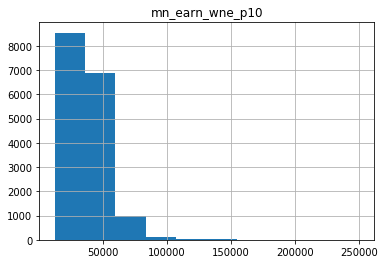

In [7]:
# Response Variable
data["mn_earn_wne_p10"] = pd.to_numeric(data["mn_earn_wne_p10"], errors='coerce')
data.hist(column='mn_earn_wne_p10')

The response variable does not look normally distributed. Applying log transformation:

In [8]:
data["log_mn_earn_wne_p10"] = np.log(data["mn_earn_wne_p10"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c43f7f410>]],
      dtype=object)

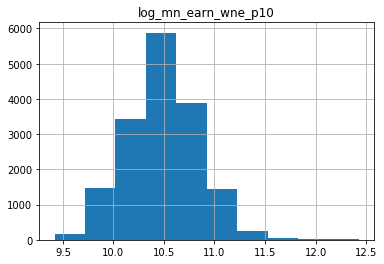

In [9]:
data.hist(column='log_mn_earn_wne_p10')

The data looks more normally distributed now.

In [10]:
df = data
df.head()

,Id,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,...,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP,C200_L4_POOLED_SUPP,C200_4_POOLED_SUPP,Year,log_mn_earn_wne_p10
0,1,100636,01230800,12308,COMMUNITY COLLEGE OF THE AIR FORCE,MONTGOMERY,AL,361126613,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996,NaN
1,2,100654,00100200,1002,ALABAMA A & M UNIVERSITY,NORMAL,AL,35762,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996,NaN
2,3,100663,00105200,1052,UNIVERSITY OF ALABAMA AT BIRMINGHAM,BIRMINGHAM,AL,352940110,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996,NaN
3,4,100672,00574900,5749,ALABAMA AVIATION AND TECHNICAL COLLEGE,OZARK,AL,36360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996,NaN
4,5,100690,02503400,25034,SOUTHERN CHRISTIAN UNIVERSITY,MONTGOMERY,AL,361173553,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996,NaN


Predictor variables selected:

In [11]:
# new dataframe with response + predictor variables only
df = data[['log_mn_earn_wne_p10', 'ADM_RATE_ALL', 'COSTT4_A', 'UGDS_BLACK', 'PPTUG_EF', 'UG25abv', 
           'PAR_ED_PCT_1STGEN', 'PCTFLOAN', 'C150_4', 'TUITIONFEE_OUT', 'TUITIONFEE_IN',
          'UGDS_WHITE', 'TUITFTE', 'AVGFACSAL', 'INC_PCT_LO', 'UGDS', 'PCTPELL', 'DEBT_MDN', 'PCTFLOAN', 'INC_PCT_H2']]

In [12]:
df.head()

,log_mn_earn_wne_p10,ADM_RATE_ALL,COSTT4_A,UGDS_BLACK,PPTUG_EF,UG25abv,PAR_ED_PCT_1STGEN,PCTFLOAN,C150_4,TUITIONFEE_OUT,TUITIONFEE_IN,UGDS_WHITE,TUITFTE,AVGFACSAL,INC_PCT_LO,UGDS,PCTPELL,DEBT_MDN,PCTFLOAN,INC_PCT_H2
0,NaN,NaN,NaN,NaN,0.9752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44141.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.0852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4072.0,NaN,3852.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0.3455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5708.0,NaN,9889.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.1458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4174.0,NaN,295.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.8667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0,NaN,60.0,NaN,NaN,NaN,NaN


In [13]:
# Converting data types 

df['PAR_ED_PCT_1STGEN'] = pd.to_numeric(df["PAR_ED_PCT_1STGEN"], errors='coerce')
df['INC_PCT_LO'] = pd.to_numeric(df["INC_PCT_LO"], errors='coerce')
df['DEBT_MDN'] = pd.to_numeric(df["DEBT_MDN"], errors='coerce')
df['INC_PCT_H2'] = pd.to_numeric(df["INC_PCT_H2"], errors='coerce')

#df['CONTROL'] = df['CONTROL'].astype('category')
#df['PREDDEG'] = df['PREDDEG'].astype('category')

In [14]:
df.head()

,log_mn_earn_wne_p10,ADM_RATE_ALL,COSTT4_A,UGDS_BLACK,PPTUG_EF,UG25abv,PAR_ED_PCT_1STGEN,PCTFLOAN,C150_4,TUITIONFEE_OUT,TUITIONFEE_IN,UGDS_WHITE,TUITFTE,AVGFACSAL,INC_PCT_LO,UGDS,PCTPELL,DEBT_MDN,PCTFLOAN,INC_PCT_H2
0,NaN,NaN,NaN,NaN,0.9752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44141.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.0852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4072.0,NaN,3852.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0.3455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5708.0,NaN,9889.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.1458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4174.0,NaN,295.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.8667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0,NaN,60.0,NaN,NaN,NaN,NaN


In [15]:
# Dropping NAs

df_dropna = df
df_dropna = df_dropna.dropna(how='any')

In [16]:
df_dropna.shape

(1733, 20)

#### Dropping NA's reduces the size of the dataset by a lot. Using data imputation technique instead.

In [17]:
df.shape

(124699, 20)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124699 entries, 0 to 124698
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   log_mn_earn_wne_p10  16593 non-null   float64
 1   ADM_RATE_ALL         37385 non-null   float64
 2   COSTT4_A             20504 non-null   float64
 3   UGDS_BLACK           41164 non-null   float64
 4   PPTUG_EF             109381 non-null  float64
 5   UG25abv              52591 non-null   float64
 6   PAR_ED_PCT_1STGEN    102811 non-null  float64
 7   PCTFLOAN             34444 non-null   float64
 8   C150_4               34880 non-null   float64
 9   TUITIONFEE_OUT       56844 non-null   float64
 10  TUITIONFEE_IN        58024 non-null   float64
 11  UGDS_WHITE           41164 non-null   float64
 12  TUITFTE              106055 non-null  float64
 13  AVGFACSAL            69652 non-null   float64
 14  INC_PCT_LO           63485 non-null   float64
 15  UGDS             

Splitting data into features and targets:

In [19]:
features = df.iloc[:,1:20]
targets = df.iloc[:,0]

feature_names = list(features)
print("Feature Names:", feature_names)
#print("Target", list(targets))

Feature Names: ['ADM_RATE_ALL', 'COSTT4_A', 'UGDS_BLACK', 'PPTUG_EF', 'UG25abv', 'PAR_ED_PCT_1STGEN', 'PCTFLOAN', 'C150_4', 'TUITIONFEE_OUT', 'TUITIONFEE_IN', 'UGDS_WHITE', 'TUITFTE', 'AVGFACSAL', 'INC_PCT_LO', 'UGDS', 'PCTPELL', 'DEBT_MDN', 'PCTFLOAN', 'INC_PCT_H2']


In [20]:
# Splitting train and test set
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [21]:
X_train_scaled

,ADM_RATE_ALL,COSTT4_A,UGDS_BLACK,PPTUG_EF,UG25abv,PAR_ED_PCT_1STGEN,PCTFLOAN,C150_4,TUITIONFEE_OUT,TUITIONFEE_IN,UGDS_WHITE,TUITFTE,AVGFACSAL,INC_PCT_LO,UGDS,PCTPELL,DEBT_MDN,PCTFLOAN,INC_PCT_H2
36851,-1.003703,NaN,NaN,-0.567093,-1.235685,-0.658777,NaN,0.492252,-0.206045,-0.639448,NaN,-0.054968,1.227662,-1.960158,1.588363,NaN,0.575237,NaN,0.873567
29946,NaN,NaN,NaN,NaN,NaN,0.484039,NaN,-0.764105,-0.821376,-0.744398,NaN,-0.072934,NaN,NaN,NaN,NaN,0.244842,NaN,NaN
13695,NaN,NaN,NaN,-0.005179,NaN,0.732706,NaN,NaN,NaN,NaN,NaN,-0.084953,-0.477529,1.000164,-0.155777,NaN,-1.279855,NaN,-0.629670
38936,0.547611,NaN,NaN,-0.592560,0.207497,0.475617,NaN,NaN,-1.326660,-1.059697,NaN,-0.071579,-0.656792,-0.091797,-0.344322,NaN,-0.390533,NaN,-0.420463
53,NaN,NaN,NaN,0.449118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.559101,NaN,-0.099718,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.937670,1.495561,0.547337,-0.564218,-0.627454,-0.728511,0.251172,-0.363665,2.002759,2.069826,0.598740,-0.010150,0.768028,NaN,-0.140240,-0.601830,2.472517,0.251172,NaN
103694,0.270181,-0.659403,-0.392902,-0.079526,-0.803641,-1.162708,-0.172288,-0.272570,0.400934,-0.486425,0.986234,-0.056385,1.180282,NaN,2.008494,-0.819454,0.829387,-0.172288,NaN
860,NaN,NaN,NaN,3.084941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.366650,NaN,-0.431245,NaN,NaN,NaN,NaN
15795,NaN,NaN,NaN,0.677909,NaN,-1.103646,NaN,NaN,NaN,NaN,NaN,-0.041441,-2.510473,NaN,-0.413189,NaN,-0.509882,NaN,NaN


In [22]:
X_test_scaled

,ADM_RATE_ALL,COSTT4_A,UGDS_BLACK,PPTUG_EF,UG25abv,PAR_ED_PCT_1STGEN,PCTFLOAN,C150_4,TUITIONFEE_OUT,TUITIONFEE_IN,UGDS_WHITE,TUITFTE,AVGFACSAL,INC_PCT_LO,UGDS,PCTPELL,DEBT_MDN,PCTFLOAN,INC_PCT_H2
84897,NaN,NaN,-0.692798,-0.938006,NaN,0.994748,NaN,NaN,NaN,NaN,-1.246719,-0.092463,NaN,NaN,-0.328155,1.475865,-0.288873,NaN,NaN
91689,-0.373181,0.057540,-0.416951,-0.938006,-0.075221,0.848150,-0.085785,0.067140,0.293220,0.499083,-1.002251,-0.004571,-0.931303,0.375893,-0.322486,-0.272670,0.787706,-0.085785,-0.422844
85226,-0.640522,NaN,-0.692798,0.764989,NaN,0.295165,NaN,NaN,-0.138248,0.102646,-1.246719,-0.030291,-0.382769,-1.112676,-0.417178,0.084166,0.384726,NaN,NaN
37680,0.725991,NaN,NaN,-0.832853,-1.443740,-1.504624,NaN,0.741816,0.183050,0.397858,NaN,-0.048986,NaN,NaN,-0.312198,NaN,-0.328114,NaN,NaN
52294,NaN,NaN,NaN,-0.938006,2.517955,0.019599,NaN,NaN,-0.168953,0.074433,NaN,0.004689,-0.370069,-1.028234,-0.346212,NaN,-0.397243,NaN,-0.100665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74252,NaN,NaN,NaN,0.206772,-0.009208,0.843228,NaN,NaN,-0.140705,0.100389,NaN,-0.022232,-0.436499,NaN,-0.349151,NaN,-0.288873,NaN,NaN
117089,-0.414451,-0.454427,0.641644,-0.595846,-1.064507,-0.360885,-0.063992,-0.894581,-0.246822,-0.352587,0.650052,-0.070141,0.457859,-0.401334,0.102684,0.103454,0.321087,-0.063992,0.076375
12312,NaN,NaN,NaN,-0.938006,NaN,0.376455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.677984,-0.436075,NaN,-0.961252,NaN,NaN
21659,NaN,NaN,NaN,0.010019,-0.213621,0.478185,NaN,NaN,NaN,NaN,NaN,-0.042838,-1.301062,-0.594420,-0.320596,NaN,-0.466981,NaN,-0.392753


There are a lot of NaN values. Data imputation required. Using a python library:

In [61]:
from sklearn.impute import SimpleImputer

start = time.time()

imp = SimpleImputer(strategy='mean')
imp.fit(X_train_scaled)
X_train_scaled = imp.transform(X_train_scaled)

imp.fit(X_test_scaled)
X_test_scaled = imp.transform(X_test_scaled)
stop = time.time()

print('Time taken to Impute Values:', round((stop-start), 2), 'seconds')

Time taken to Impute Values: 0.03 seconds


In [62]:
# print(X_train_scaled)
# print(X_test_scaled)

In [25]:
y_train.fillna(y_train.mean(), inplace=True)
y_test.fillna(y_train.mean(), inplace=True)

In [26]:
print(type(X_train_scaled))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [27]:
print("Training Data shape",X_train_scaled.shape)
print("Test Data shape", X_test_scaled.shape)

Training Data shape (99759, 19)
Test Data shape (24940, 19)


In [28]:
temp = X_train_scaled
y_temp = y_train.values

trainingData = np.column_stack((temp, y_temp))

In [29]:
temp2 = X_test_scaled
y_temp2 = y_test.values

testData = np.column_stack((temp2, y_temp2))

In [30]:
trainingData.shape

(99759, 20)

In [31]:
testData.shape

(24940, 20)

### 1. Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor 

start = time.time()
RF_model = RandomForestRegressor(n_estimators=1000, random_state=0)
RF_model.fit(X_train_scaled, y_train)
stop = time.time()

In [33]:
print('Time taken to train using Random Forest:', round((stop-start), 2), 'seconds')

Time taken to train using Random Forest: 867.84 seconds


- **Model Evaluation**

In [63]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

predicted_train = RF_model.predict(X_train_scaled)
predicted_test = RF_model.predict(X_test_scaled)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)

#print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data Spearman correlation: 0.337
Test data Pearson correlation: 0.469


- **Feature Importance**

In [35]:
features_importance = RF_model.feature_importances_
print(features_importance)

[0.03049218 0.02301388 0.02213579 0.03337603 0.13543116 0.09844589
 0.01696476 0.01937453 0.03238953 0.03376114 0.03245242 0.07968022
 0.07826944 0.06216233 0.05894464 0.08085882 0.11474239 0.0168912
 0.03061366]


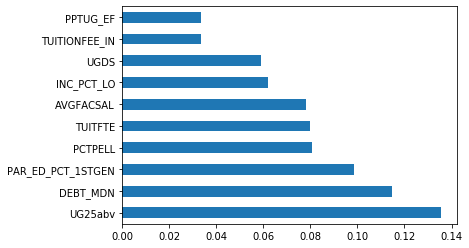

In [36]:
# Feature Importance 
feature_importances = pd.Series(RF_model.feature_importances_, index=features.columns)
feature_importances.nlargest(10).plot(kind='barh')

- **Hyperparameter Tuning: Grid Search**

In [37]:
# Tuning Hyper parameters - Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

# Instantiate the grid search model
start = time.time()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
#grid_search.fit(X_train_scaled, y_train)
grid_search.fit(X_test_scaled, y_test)
stop = time.time()

print('Time taken for Grid Search:', round((stop-start),2),'seconds')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 27.0min finished


Time taken for Grid Search: 1630.74 seconds


In [38]:
print('Best Parameters Found:',grid_search.best_params_)
print('Best Score Found:', grid_search.best_score_ )

Best Parameters Found: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
Best Score Found: 0.3276857226863723


In [39]:
best_grid = grid_search.best_estimator_
print('Best Estimator:', best_grid)

Best Estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


- **Hyperparameter Tuning: Randomized Search**

In [40]:
# Randomized Search

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
n_estimators = [100, 200, 300, 1000]

# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
max_features = [2, 3]

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
max_depth = [80, 90, 100, 110]

# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {
                'bootstrap': [True],
                'max_depth': max_depth,
                'max_features': max_features,
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': min_samples_split,
                'n_estimators': n_estimators,
            }

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [80, 90, 100, 110],
 'max_features': [2, 3],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [5, 10],
 'n_estimators': [100, 200, 300, 1000]}


In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
start = time.time()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
# rf_random.fit(X_train_scaled, y_train)
rf_random.fit(X_test_scaled, y_test)
stop = time.time()

print('Time taken for Random Grid Search:', round((stop-start), 2),'seconds')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.9min finished


Time taken for Random Grid Search: 626.41 seconds


In [42]:
print('Best Parameters Found:',rf_random.best_params_)
print('Best Score Found:', rf_random.best_score_ )

Best Parameters Found: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}
Best Score Found: 0.32983964691923456


### 2. Gradient Boost

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
import time

params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}


start = time.time()
GB_model = GradientBoostingRegressor(**params)
GB_model.fit(X_train_scaled, y_train)
stop = time.time()

print('Time taken to train using Gradient Boost Model:', round((stop-start), 2), 'seconds')

Time taken to train using Gradient Boost Model: 303.8 seconds


- **Model Evaluation**

In [44]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

predicted_train = GB_model.predict(X_train_scaled)
predicted_test = GB_model.predict(X_test_scaled)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)

print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data R-2 score:   0.2
Test data Spearman correlation: 0.328
Test data Pearson correlation: 0.503


- **Feature Importance**

In [45]:
features_importance = GB_model.feature_importances_
print(features_importance)

[0.00746528 0.03134686 0.01006165 0.0013697  0.30867955 0.05669149
 0.01058782 0.00954911 0.02594259 0.02955885 0.04104157 0.01840755
 0.13456755 0.0332366  0.01547718 0.11427854 0.1225859  0.01179006
 0.01736215]


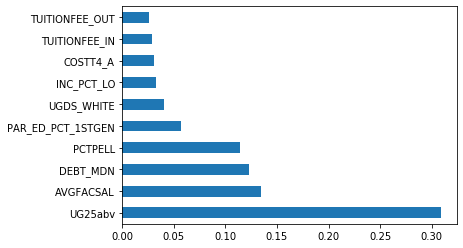

In [46]:
# Feature Importance 
feature_importances = pd.Series(GB_model.feature_importances_, index=features.columns)
feature_importances.nlargest(10).plot(kind='barh')

- **Hyperparameter Tuning: Grid Search**

In [47]:
# Tuning Hyper parameters - Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

gb = GradientBoostingRegressor()

# Instantiate the grid search model
start = time.time()
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, verbose = 2,  n_jobs = -1)
# Fit the grid search to the data
#grid_search.fit(X_train_scaled, y_train)
grid_search.fit(X_test_scaled, y_test)
stop = time.time()

print('Time taken for Grid Search:', round((stop-start), 2),'seconds')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 72.2min finished


Time taken for Grid Search: 4358.46 seconds


In [48]:
print('Best Parameters Found:',grid_search.best_params_)
print('Best Score Found:', grid_search.best_score_ )

Best Parameters Found: {'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 200}
Best Score Found: 0.34853303293334753


In [49]:
best_grid = grid_search.best_estimator_
print('Best Estimator:', best_grid)

Best Estimator: GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=80,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=12,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


- **Hyperparameter Tuning: Randomized Search**

In [50]:
# Randomized Search

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {
                'max_depth': max_depth,
                'max_features': max_features,
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': min_samples_split,
                'n_estimators': n_estimators
            }

pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}


In [51]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
start = time.time()
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
#gb_random.fit(X_train_scaled, y_train)
gb_random.fit(X_test_scaled, y_test)
stop = time.time()

print('Time taken for Random Grid Search:', round((stop-start), 2),'seconds')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.4min finished


Time taken for Random Grid Search: 1111.99 seconds


In [52]:
print('Best Parameters Found:',gb_random.best_params_)
print('Best Score Found:', gb_random.best_score_ )

Best Parameters Found: {'n_estimators': 65, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 23}
Best Score Found: 0.3516649400100566
